# Exploring Titanic Dataset

In [28]:
#First load the dataset and take a look on our data. To do that we load our csv file into Pandas dataframe using 
#read_csv function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
path = '/Users/iulia/Documents/Docs/StudyMaterials/OnlineCourses/Udacity/DAND/P2/P2_project/titanic-data.csv'
df = pd.read_csv(path, index_col = 0)
df.index.name = None

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Posing Qs:
The big Q here is what main factors contributed to Titanic passengers survival likelyhood?
And more specifically :
1. Did the travelling class make passengers more likely to survive?
2. Were young people / children more likely to survive thanthe old ?
3. Was women survival rate higher than men  ?
4. Was people travelling with family (children or spouse) survival rate higher than for singletons?

In order to reply any of these questions let's look for some potential problems in our dataset and do some cleaning 

### Data Wrangling
Now let's prepare our dataset for exploration: clean it, fill in missing values, create additional columns to help the analysis

In [29]:
#Basic sanity check to detect any obviuos abnormalities in data
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [30]:
#Check for missing data
df.isnull().sum()
#https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-the-column-in-panda-data-frame

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [31]:
##A lot of empty cells in ['Cabin'] column but I don't think it contains a lot of useful info for our analysis so we 
#can simply delete it
df = df.drop('Cabin', 1)

#We can also delete ['Ticket'] column as it doesn't bring any use to our data analysis
df = df.drop('Ticket',1)

Dealing with missing values in ['Age'] column is a bit more tricky as we cannot drop all the rows with missing 
values (in that case we lose some 20% of our data).

Instead we group all the passengers by title and fill missing values in ['Age'] column with each title's median value of ['Age'] column. Title is giving as a rough indication of the age (e.g. 'Miss' is likely to be younger than 'Mrs.' and 'Col' must be older than 'Master'), also filling missing values for each group separately will reduce the artificial decrease in variability and bias, which is inevitable when we perform imputation of the missing data with median or mean.
https://chrisalbon.com/python/pandas_missing_data.html

# THINKING TO MYSELF: As an option we can try to scrape the information about passengers age from the web, Titanic passenger lists must be available online (https://www.encyclopedia-titanica.org/titanic-passenger-list/). Doing it this way the correct information about age will be available for free, and no need to make imputation which in any case will not be 100 % correct


In [32]:
#Extracting each passanger's title to a new column ['Title']
#It will also be useful to split the column['Name'] into ['First_name] and ['Last_name], it will be useful for 
#future analysis, we also remove maiden names for married women as we don't need them in our analysis.

import re

title_list = []
last_name_list = []
first_name_list = []

for name in df['Name']:
    #extracting last name
    last_name_extract = name.split(',')
    last_name = last_name_extract[0]
    last_name_list.append(last_name)
    
    #extracting title
    title_extract = last_name_extract[1].split('.')
    title = title_extract[0]
    title_list.append(title)
    
    #extracting first name
    first_name = title_extract[1]
    #removing maiden names
    first_name = re.sub("\([^)]*\)", " ", first_name)
    first_name_list.append(first_name)
      
#creating Pandas series to be append to our df    
title_series = pd.Series(title_list, index=df.index)
last_name_series = pd.Series(last_name_list, index=df.index)
first_name_series = pd.Series(first_name_list, index=df.index)

#Very gentle introduction to regular expressions in Python https://docs.python.org/2/howto/regex.html#regex-howto
#Solution to removing text in brackets :
#https://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex

#Adding series to our dataframe
df['Title'] = title_series
df['Last_name'] = last_name_series
df['First_name'] = first_name_series

#Now we cand drop ['Name'] column as we don't need it anymore
df = df.drop('Name', 1)

In [33]:
#Filling missing values in our ['Age'] column :
df['Age']= df['Age'].fillna(df.groupby("Title")["Age"].transform("median"))

In [34]:
#We still have several missing values in ['Embarked'] column. Let's have a look on the rows with missing data:
df[df['Embarked'].isnull() == True]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Last_name,First_name
62,1,1,female,38.0,0,0,80.0,NaN,Miss,Icard,Amelie
830,1,1,female,62.0,0,0,80.0,NaN,Mrs,Stone,George Nelson


In [35]:
#Let's see what the typical fare for 1st class tickets for each embarkation
#port
df[df['Pclass'] ==1].groupby('Embarked')['Fare'].median()

Embarked
C    78.2667
Q    90.0000
S    52.0000
Name: Fare, dtype: float64

In [36]:
#The fare paid is close to fare normally paid for 'C' embarkation port, so we fill
#the cells with 'C' port
df.set_value(62, 'Embarked','C')
df.set_value(830, 'Embarked','C')
#http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.DataFrame.set_value.html

#Checking if there still any missing values left in out dataframe
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Last_name     0
First_name    0
dtype: int64

In [37]:
#We also create a new column ['Family'] which sums ['SibSp'] and ['Parch'] columns. 
#This new column might be of use to us while answering Q4 from our question list and to create it we use vectorized 
#operation on two existing columns from our dataframe

df['Family'] = df['SibSp'] + df['Parch']

In [38]:
#In context of the current analysis and specifically for being able to reply our Q3, we modify ['Sex'] column adding 
#new category 'child' for passengers under 15 y.o.

df.loc[df['Age']<=15, 'Sex'] = 'child'
#http://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/#ix-selection

### Data Exploration

We start off with drawing a scatter matrix for each pair of variables, seaborn provides a pairplot option to achieve that.

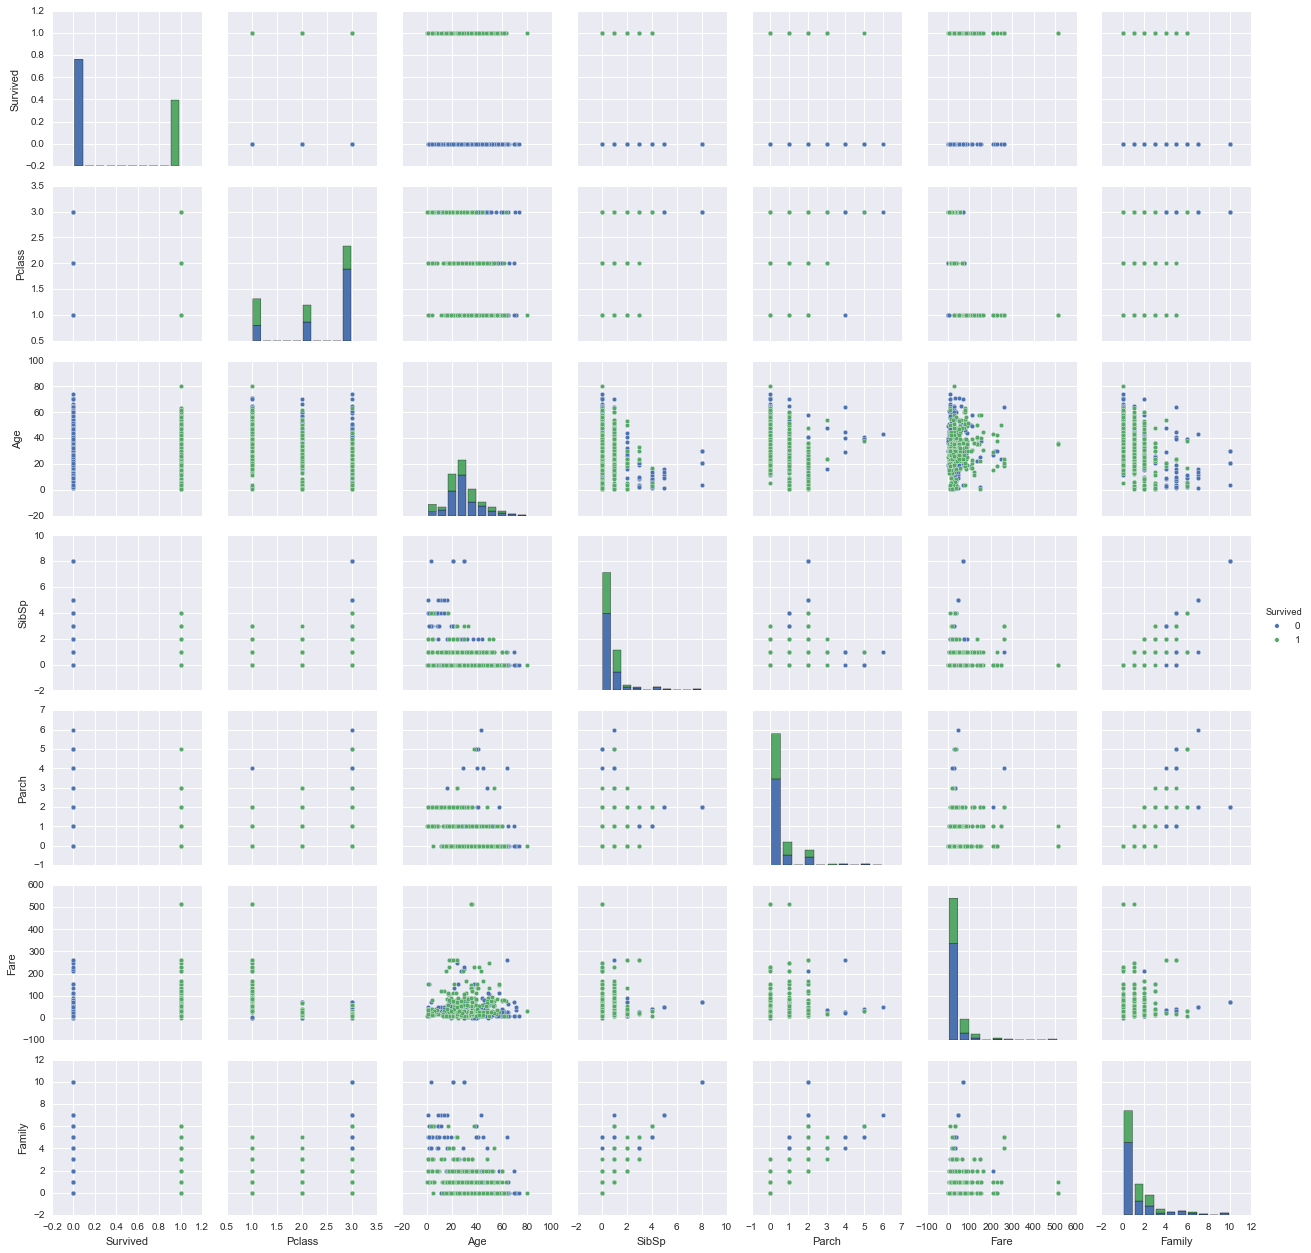

In [39]:
sns.pairplot(df, hue = 'Survived')

Well, the most informative so far were diagonal histograms so we really need to look into bivariate analysis here

Let's also build a correlation matrix (calculate Pearson's r for each pair of numeric variables in our dataframe) the get the basic understanding of how our variables correlate with each other. We will perform this opertaion only on numeric data and utilize Pandas built-in function `corr()` for it.

In [40]:
#We exclude our categorical variables ['Survived'] and ['Pclass'] from the correlation matrix as Pandas might 
#treat them numeric data and calculation results might be misleading
df[df.columns[3:]].corr('pearson')

,Age,SibSp,Parch,Fare,Family
Age,1.000000,-0.265602,-0.188122,0.097944,-0.275513
SibSp,-0.265602,1.000000,0.414838,0.159651,0.890712
Parch,-0.188122,0.414838,1.000000,0.216225,0.783111
Fare,0.097944,0.159651,0.216225,1.000000,0.217138
Family,-0.275513,0.890712,0.783111,0.217138,1.000000


We see some slight negative correlation between ['Age'] and ['Family'] variables, slight positive correlation between ['Family'] and ['Fare'] and relatively strong positive correlation between ['Parch'] and ['SibSp'] variables. We investigate these variables further along with answering Qs from our question list.

Now let's directly dive in our data exploration and answer the posed Qs one by one

### 1. Did the travelling class make passengers more likely to survive?


To answer this question let's use Pansdas `groupby()` function to group passengers according to the class and `size()` to see the size of each group

In [41]:
df.groupby(['Pclass', 'Survived']).size()
#https://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-in-a-group-in-pandas-group-by-object

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64

And looks like the passenger class is one of the factors that made people likely to survive, as we can see: 136 out of 216 (about 63%) 1st class passenegers survived, whereas for 2d and 3d class this percentage is substantially lower : 47% and 24% respectively.

Let's visualize it in seaborn by countplot, which is a version of barplot and helps to show the number of observations for each category in categorical data, which is exactly what we need now).
https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial

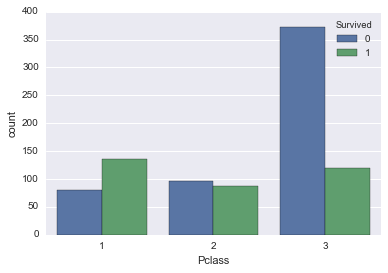

In [42]:
sns.countplot(x = 'Pclass', hue = 'Survived', data = df)

Now let's move on to answering the second question from our question list:
### 2. Were young people / children more likely to survive than the old ?

Ok, we take a look on our ['Age'] column.
First visualize the distribution of passenger ages from our dataset and get some basic statistic on it

In [43]:
df['Age'].describe()

count    891.000000
mean      29.390202
std       13.265322
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

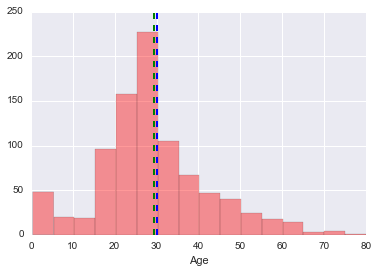

In [44]:
plot = sns.distplot(df['Age'],bins = 16, kde = False, color = 'red')

#Let's draw the mean and the median of the distribution
plot.axvline(df['Age'].mean(), color='g', linestyle='dashed', linewidth=2)
plot.axvline(df['Age'].median(), color='b', linestyle='dashed', linewidth=2)

#https://seaborn.pydata.org/tutorial/distributions.html
#https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib

The distribution of the age values is quite skewed to the right, with a distinct peak between 25 - 30, average at 29.39 and center of the distribution a bit further to the left, around 29.

Let's modify our histo to see the age breakup for passengers and check out the survival for each age group

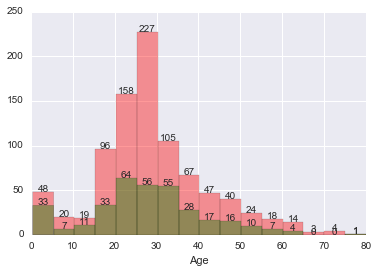

In [45]:
plot1 = sns.distplot(df['Age'],bins = 16, kde = False,  color = 'red')
plot2 = sns.distplot(df['Age'][df['Survived'] == 1], bins = 16, kde = False, color = 'green')

for p2 in plot2.patches:        
    height2 = p2.get_height()
    plot2.text(p2.get_x() + p2.get_width()/2.,
                height2,
                '%d'%(height2),
                ha="center") 
#https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn       

Seems like children under 15 y.o. and young people between 20 - 35 y.o. account for the biggest part of the survivors, while the survival chances for older people of age above 55 y.o. seems to be way lower. Let's calculate the fraction pof survivors for three age groups: children(age: 0 - 15), adults (15 - 54), old people (>55). 

In [46]:
survival_old = float(df['Survived'][df['Age'] >=55][df['Survived'] == 1].count())/(df['Survived'][df['Age']>=55].count())
survival_adults = float(df['Survived'][df['Age'] <55][df['Age']>15][df['Survived'] == 1].count())/(df['Survived'][df['Age']<55][df['Age']>15].count())
survival_kids = float(df['Survived'][df['Age'] <=15][df['Survived'] == 1].count())/(df['Survived'][df['Age']<=15].count())
print survival_old
print survival_adults
print survival_kids

0.309523809524
0.364829396325
0.586206896552


Indeed survival ratio for children is way higher than for other two age groups, while the older people still have lower chances for survival comparing to adults. 

Now let's explore if there is a trend between passenger class and age (mb older people prefer travelling with more comfort, paying extra for better class?)

In [47]:
#Average age for passengers of each class
df['Age'].groupby(df['Pclass']).mean()
#https://chrisalbon.com/python/pandas_apply_operations_to_groups.html

Pclass
1    37.309815
2    29.787120
3    25.757475
Name: Age, dtype: float64

Indeed the average age of the passengers decrease with higher class. Let's utilize scatter plot to make our observation more visual and draw further conclusions.

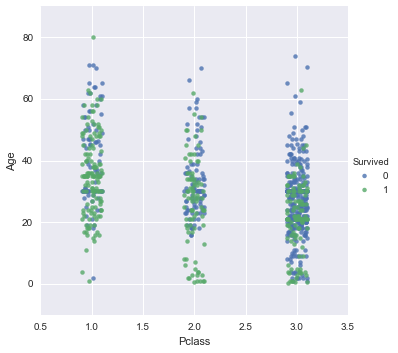

In [56]:
#We add some jitter to the scatterplot to make it more readable
sns.lmplot('Pclass', 'Age',
           data=df,
           fit_reg=False,
           hue="Survived", x_jitter = .1)


Just as we observed above, older people have lower chances for servival regardless of the class they travelled (even among the 1st class passengers, the survivors age is mostly below 40, while the biggest part of passengers over 55 in all three classes did not survive)

### 3. Were women and children likely survive rather then men?

Our assumption (which is based on the famous movie:))) is that during the ship crush women and children mostly survived because they should have been saved first, so let's  check if this guess is correct! 

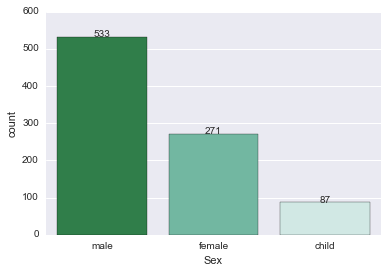

In [49]:
#First let's see how many people in our gender groups and the number of children
plot = sns.countplot(x = 'Sex', data = df, palette = 'BuGn_r')
for p in plot.patches:        
    height = p.get_height()
    plot.text(p.get_x() + p.get_width()/2.,
                height,
                '%d'%(height),
                ha="center") 

Now let's investigate our age variable in conjunction with other variables, let's take the family size.
To see the correlation between these two variable we first calculate Pearson's r with the help of built-in function in Pandas, then we make it visual with scatter plot in seaborn

The biggest part of the passengers are men (533), while women account for almost half of that number (271), and children is the least numerous among the three groups with 87 passengers belong to it. 

Next we build a barplot to see the proportions of those who survived for each of the categoris in our ['Sex'] column

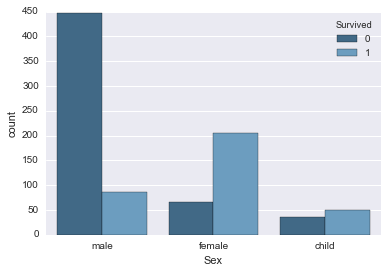

In [50]:
sns.countplot(x = 'Sex', hue = 'Survived', data = df, palette = 'Blues_d')

Seems like our assumption is totally valid and women and children had far more chances to survive the Titanic crush than men. 

Let's explore is there any trend between ['Age'] and ['Sex'] variables, maybe older man are tend to travell more than older women, or maybe the latter are more adventurous ?

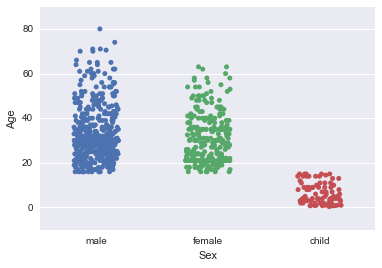

In [51]:
sns.stripplot(x="Sex", y="Age", data=df, jitter = .2)

Indeed most of the passengers above 60 y.o. are men while women passengers age slightly exceeds 60 y.o. Let's add ['Pclass'] category to our scatterplot to check the class preferances for passengers of different ages in different gender groups.

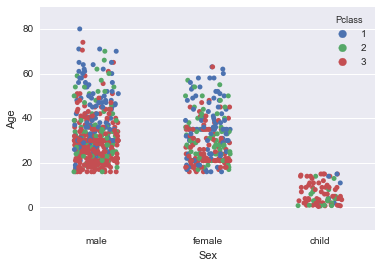

In [52]:
sns.stripplot(x="Sex", y="Age", data=df, jitter = .2, hue = 'Pclass')

Looks like male passengers do prefer to save money and travel 3d class (specifically male between 20 and 40 y.o.), while female passengers probably more demanding so they seem to travell more in 1st or 2d class, whereas only the youngest around 20 y.o. went for the 3d class. Assuming that children were travelling the same class as their parents, most of the families with kids were travelling 3d class. 
To double check this conclusion we make bivariate barplot for gender groups and passenger class

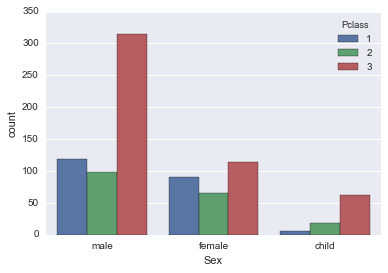

In [53]:
plot = sns.countplot(x = 'Sex', hue = 'Pclass', data = df)

Just as we concluded above !

Now let's answer our last Q before drawing final conclusions

### 4. Was people travelling with family (children or spouse) survival rate higher than for singletons?

For starter let's make a histogram to see the distribution of the data in our ['Family'] column

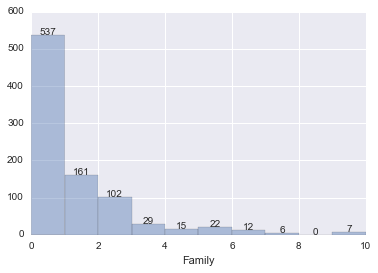

In [78]:
plot = sns.distplot(df['Family'],bins = 10, kde = False)
for p in plot.patches:        
    height = p.get_height()
    plot.text(p.get_x() + p.get_width()/2.,
                height,
                '%d'%(height),
                ha="center") 

60% of the passengers (537 people) where travelling alone, while 29.5% where travelling with 1-2 family members and the remaining 10.5% of the passengers where travelling with more than 2 family members. 

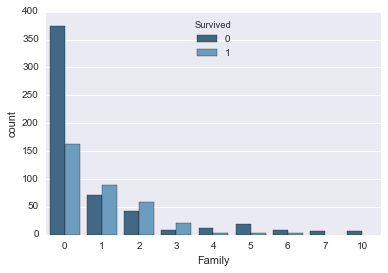

In [81]:
sns.countplot(x = 'Family', hue = 'Survived', data = df, palette = 'Blues_d')

Looks like they did! As per our countplot above, almost all the passengers travelling with more than 3 family members did not survive the crush, while singletons and small families (not more than 3 family member) had fair chances for survival

Finally let's also check out the passenger class breakup for singletons and families.

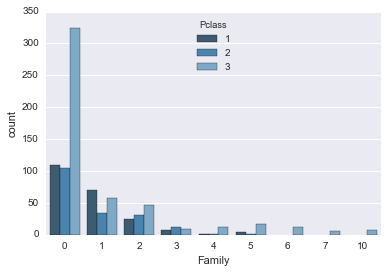

In [82]:
sns.countplot(x = 'Family', hue = 'Pclass', data = df, palette = 'Blues_d')

Singletons tend to travel 3d class, however a lot of them still go for 1st and 2d classes. Small families with family members up to 3 seem to have no distinct preferance for the class they are travelling (there is an equal distribution of the data for them), while big families obviously go for 3d class. Coming back to the correlation between ['Fare'] and ['Family'] in our correlation matrix, we can see now, that the bigger the familly the lower the class and the lower the fare. 